# Data Ingestion

Downloading Data from Kaggle

In [1]:
# setting up to use kaggle dataset

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d adityajn105/flickr8k


Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 98% 1.01G/1.04G [00:07<00:00, 135MB/s]
100% 1.04G/1.04G [00:07<00:00, 154MB/s]


In [3]:
mkdir dataset

In [4]:
!unzip flickr8k.zip



Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [5]:
with open("/content/captions.txt","r") as f :
  lines=f.readlines()
  print(lines[:10])


['image,caption\n', '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n', '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n', '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n', '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n', '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n']


# Data Preprocessing

# first lets get the tabular form

In [5]:
import pandas as pd

In [6]:
data=pd.read_csv("/content/captions.txt")

In [7]:
data.head(10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from textwrap import wrap

reading image : loading -> normalizing

In [9]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

In [10]:
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    plt.subplot(5 , 5, 1)
    plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
    image = readImage(f"/content/Images/{temp_df.image[1]}")
    print(type(image))
    plt.imshow(image)
    plt.title("\n".join(wrap(temp_df.caption[1], 20)))
    plt.axis("off")

<class 'numpy.ndarray'>


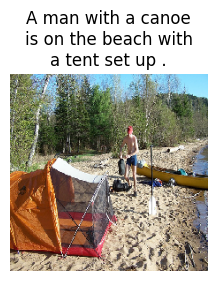

In [11]:
display_images(data.sample(15))

### Text PReprocessing

In [12]:
def text_preprocessing(data):
  data['caption']=data['caption'].apply(lambda x : x.lower())
  data['caption']=data['caption'].apply(lambda x : x.replace("[^A-Za-z]",""))
  data['caption']= "startseq "+data['caption']+" endseq"
  return data



In [13]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way . endseq',
 'startseq a girl going into a wooden building . endseq',
 'startseq a little girl climbing into a wooden playhouse . endseq',
 'startseq a little girl climbing the stairs to her playhouse . endseq',
 'startseq a little girl in a pink dress going into a wooden cabin . endseq',
 'startseq a black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tri-colored dog playing with each other on the road . endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street . endseq',
 'startseq two dogs of different breeds looking at each other on the road . endseq',
 'startseq two dogs on pavement moving toward each other . endseq']

# Tokenization

tokenizing the texts and converting them into tokens (numbers)

using keras's tokenizer

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [15]:
tokenizer=Tokenizer()

In [16]:
tokenizer.fit_on_texts(captions)

In [17]:
tokenizer.word_index

{'a': 1,
 'startseq': 2,
 'endseq': 3,
 'in': 4,
 'the': 5,
 'on': 6,
 'is': 7,
 'and': 8,
 'dog': 9,
 'with': 10,
 'man': 11,
 'of': 12,
 'two': 13,
 'white': 14,
 'black': 15,
 'boy': 16,
 'are': 17,
 'woman': 18,
 'girl': 19,
 'to': 20,
 'wearing': 21,
 'at': 22,
 'people': 23,
 'water': 24,
 'red': 25,
 'young': 26,
 'brown': 27,
 'an': 28,
 'his': 29,
 'blue': 30,
 'dogs': 31,
 'running': 32,
 'through': 33,
 'playing': 34,
 'while': 35,
 'shirt': 36,
 'down': 37,
 'standing': 38,
 'ball': 39,
 'little': 40,
 'grass': 41,
 'snow': 42,
 'child': 43,
 'person': 44,
 'jumping': 45,
 'over': 46,
 'three': 47,
 'front': 48,
 'sitting': 49,
 'holding': 50,
 'up': 51,
 'field': 52,
 'small': 53,
 'by': 54,
 'large': 55,
 'green': 56,
 'one': 57,
 'group': 58,
 'yellow': 59,
 'her': 60,
 'walking': 61,
 'children': 62,
 'men': 63,
 'into': 64,
 'air': 65,
 'beach': 66,
 'near': 67,
 'mouth': 68,
 'jumps': 69,
 'another': 70,
 'for': 71,
 'street': 72,
 'runs': 73,
 'its': 74,
 'from': 75,

In [18]:
vocab_size=len(tokenizer.word_index)+1

In [19]:
vocab_size

8496

In [20]:
max_len_sentence=max(len(caption.split()) for caption in captions)

In [21]:
max_len_sentence

40

---
number of words 8496
---
max_len=42

In [22]:
images=data['image']
num_images=len(images)

In [23]:
num_images

40455

In [24]:
len(data['caption'])

40455

In [25]:
def gimme_split(n,num_image):
  split_amt=round(n*num_image)
  train=data[:split_amt]
  test=data[split_amt:]
  return train,test

In [26]:
train,test=gimme_split(0.85,num_images)

In [27]:
len(train)

34387

In [28]:
len(test)

6068

In [29]:
type(train)

pandas.core.frame.DataFrame

In [30]:
train.head(3)

,image,caption
0,1000268201_693b08cb0e.jpg,startseq a child in a pink dress is climbing u...
1,1000268201_693b08cb0e.jpg,startseq a girl going into a wooden building ....
2,1000268201_693b08cb0e.jpg,startseq a little girl climbing into a wooden ...


In [31]:
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [32]:
test.head(3)

,image,caption
0,3688858505_e8afd1475d.jpg,startseq a girl is wear a green dress . endseq
1,3688858505_e8afd1475d.jpg,startseq blonde girl wearing green dress stand...
2,3688858505_e8afd1475d.jpg,startseq woman in green dress being observed e...


# feature Extraction


In [33]:
# we will use resnet50: having 2048 embedding
# good for low data

In [34]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

In [56]:
model=ResNet50()
feature_extractor=Model(inputs=model.input,outputs=model.layers[-2].output)



In [35]:
# import pickle

# with open("features.pkl", "rb") as f:
#     features = pickle.load(f)


In [37]:
from tqdm import tqdm

In [38]:
import os
import numpy as np

In [39]:
img_size=224
features={}
image_path="/content/Images/"

#iterating over all images and extracting features
for image in tqdm(data["image"]):
  img=load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
  img=img_to_array(img)
  img=img/255.
  img=np.expand_dims(img,axis=0)
  feature=feature_extractor.predict(img,verbose=0)
  features[image]=feature

100%|██████████| 40455/40455 [57:43<00:00, 11.68it/s]


# Data for the model

input will be like :
img embedding - text embedding for .training:
text_embedding passed 1 by 1

(image embedding, caption tokens)

Model learning :

like in transformers/seq2seq

model will see past words(captions) along with img embedding and predict next word


Inference (generate captions)

-Image → Embedding (same CNN).

-Start with <start> token.

-Loop until <end> token or max length:

-Feed image embedding + generated words so far.

-Model predicts next word.

-Append that word to the caption.

-Final caption = sequence of predicted words.

In [36]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [39]:
image_path="/content/Images"

In [40]:

class imgData2modelData(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

        super().__init__()

        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size, :]
        X1, X2, y = self.__getdata(batch)


        return (np.array(X1), np.array(X2)), np.array(y)

    def __getdata(self, batch):
        X1, X2, y = [], [], []

        for idx, row in batch.iterrows():
            image = row[self.X_col]
            caption = row[self.y_col]

            # Get image feature
            feature = self.features[image][0]

            # Process caption
            seq = self.tokenizer.texts_to_sequences([caption])[0]

            for i in range(1, len(seq)):
                in_seq = seq[:i]
                out_seq = seq[i]

                # Pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]

                # One-hot encode output
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]

                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)

        return X1, X2, y



In [41]:

def create_train_val_split(train_data, val_split=0.2):
    val_size = int(len(train_data) * val_split)
    val_data = train_data.tail(val_size).reset_index(drop=True)
    train_data = train_data.head(len(train_data) - val_size).reset_index(drop=True)
    return train_data, val_data


train_data, val_data = create_train_val_split(train, val_split=0.2)


train_generator = imgData2modelData(
    df=train_data,
    X_col='image',
    y_col='caption',
    batch_size=32,
    directory=image_path,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_len_sentence,
    features=features,
    shuffle=True
)

val_generator = imgData2modelData(
    df=val_data,
    X_col='image',
    y_col='caption',
    batch_size=32,  # REDUCED batch size
    directory=image_path,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_len_sentence,
    features=features,
    shuffle=False
)


# Modelling

In [42]:
from tensorflow.keras.layers import Input,Dense,Dropout,LSTM,concatenate,Embedding,Reshape,add

In [43]:
input1=Input(shape=(2048,))
input2=Input(shape=(max_len_sentence,))


Ifeatures=Dense(256,activation='relu')(input1)
Ifeatures_reshaped=Reshape((1,256),input_shape=(256,))(Ifeatures)

#for sentence featuring
Sfeatures=Embedding(vocab_size,256,mask_zero=False)(input2)
merged=concatenate([Ifeatures_reshaped,Sfeatures],axis=1)

sentence_features=LSTM(256)(merged)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
x=Dropout(0.5)(sentence_features)
x=add([x,Ifeatures])

x=Dense(128,activation="relu")(x)
x=Dropout(0.5)(x)
output=Dense(vocab_size,activation='softmax')(x)


In [45]:
caption_model=Model(inputs=[input1,input2],outputs=output)
caption_model.compile(loss="categorical_crossentropy",optimizer="adam",  metrics=["accuracy"])

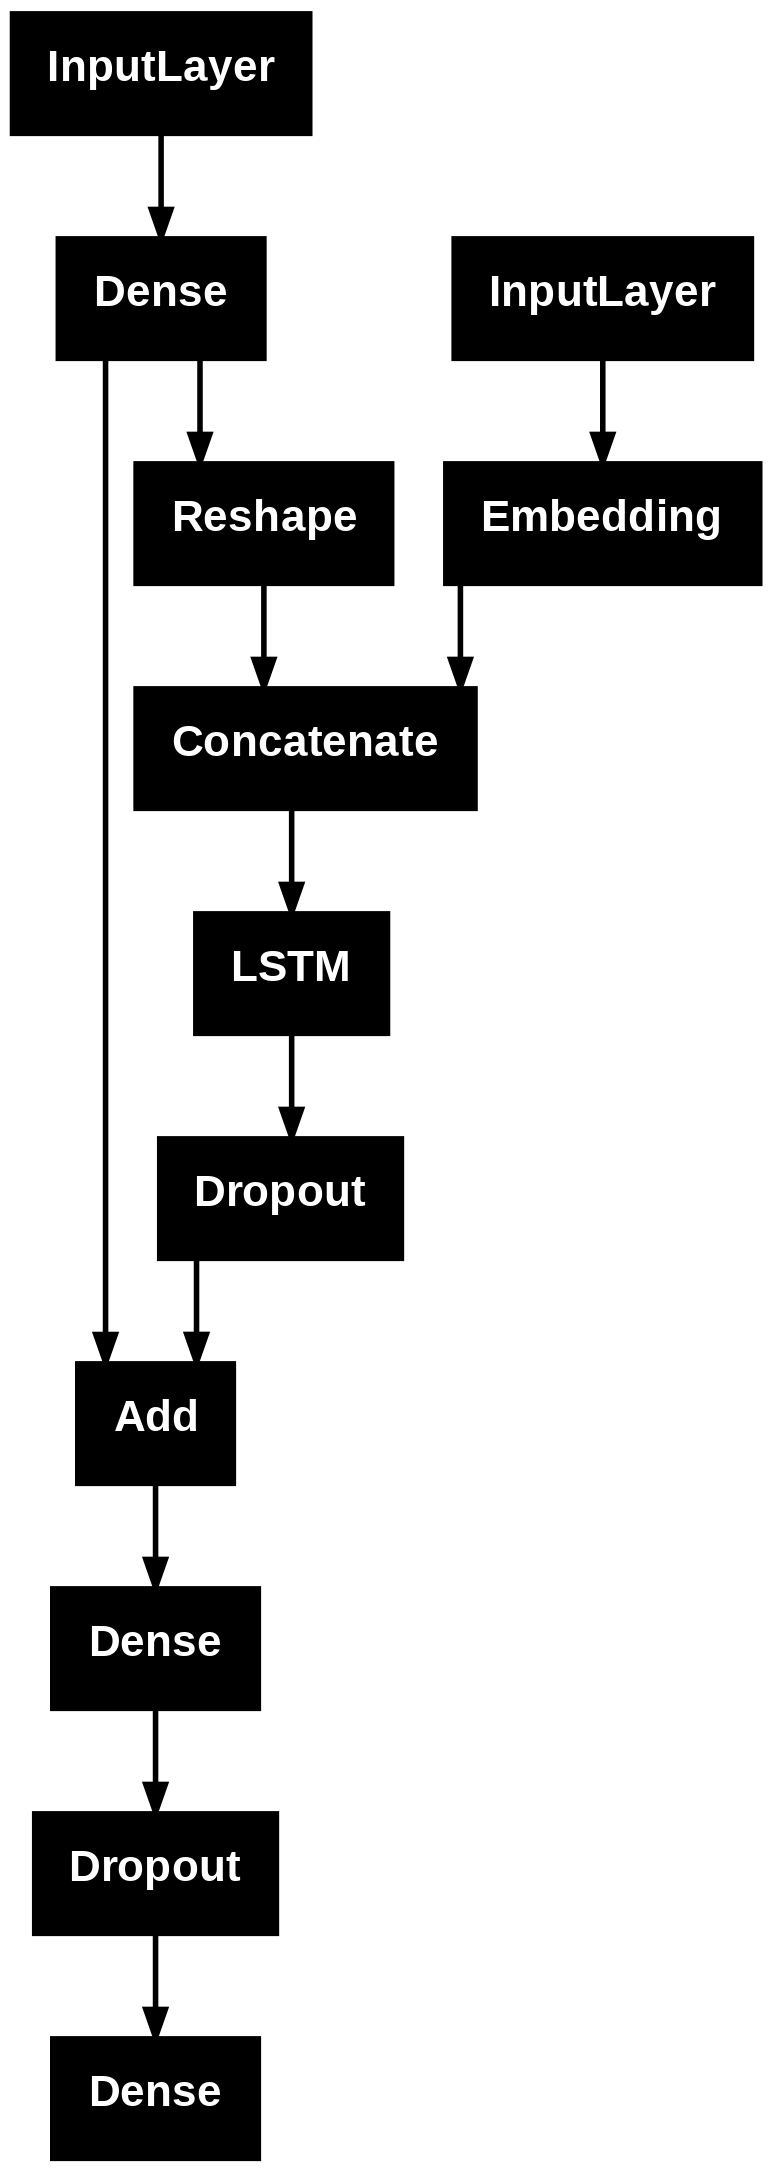

In [46]:
from tensorflow.keras.utils import plot_model

plot_model(caption_model)

In [47]:
from tensorflow.keras.callbacks import EarlyStopping ,ModelCheckpoint,ReduceLROnPlateau

In [48]:
model_name='captioner.keras'

checkpoint=ModelCheckpoint(model_name,monitor='val_loss',
                           mode='min',
                           save_best_only=True,
                           verbose=1)
earlystopping=EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=1,restore_best_weights=True)


learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=1e-5)

In [51]:
hist = caption_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction],
    verbose=1
)

Epoch 1/10
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1940 - loss: 5.2446
Epoch 1: val_loss improved from inf to 4.19579, saving model to captioner.keras
859/859 ━━━━━━━━━━━━━━━━━━━━ 58s 62ms/step - accuracy: 0.1941 - loss: 5.2434 - val_accuracy: 0.2840 - val_loss: 4.1958 - learning_rate: 0.0010
Epoch 2/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2893 - loss: 4.1442
Epoch 2: val_loss improved from 4.19579 to 3.97475, saving model to captioner.keras
859/859 ━━━━━━━━━━━━━━━━━━━━ 76s 59ms/step - accuracy: 0.2893 - loss: 4.1441 - val_accuracy: 0.3061 - val_loss: 3.9747 - learning_rate: 0.0010
Epoch 3/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3091 - loss: 3.9135
Epoch 3: val_loss improved from 3.97475 to 3.85054, saving model to captioner.keras
859/859 ━━━━━━━━━━━━━━━━━━━━ 51s 59ms/step - accuracy: 0.3091 - loss: 3.9135 - val_accuracy: 0.3184 - val_loss: 3.8505 - learning_rate: 0.0010
Epoch 4/10
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accurac

# Inference

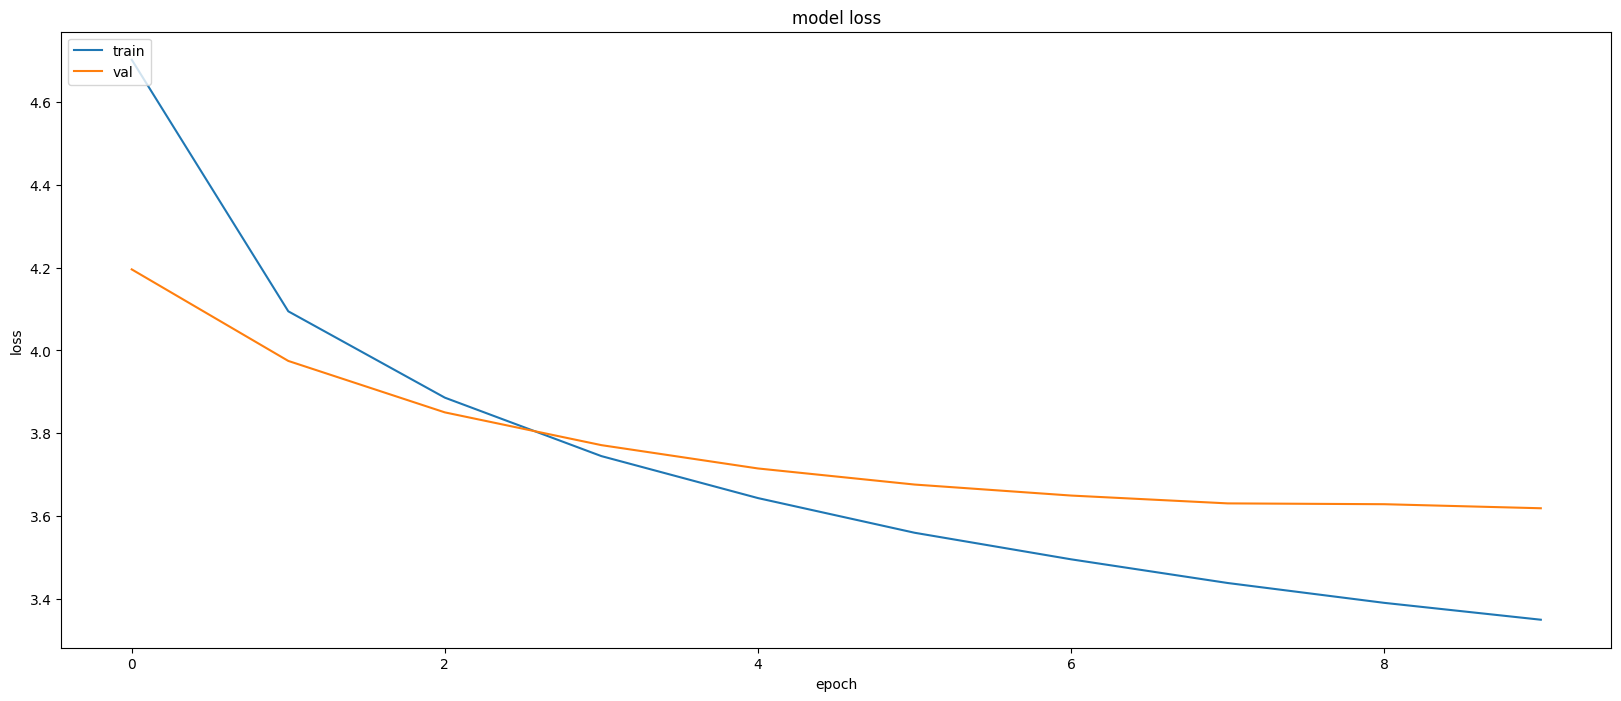

In [52]:
#seeing learning curve

plt.figure(figsize=(20,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title("model's loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# TESTING

In [53]:
# first fn to predict

def i2w(i,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index==i:
      return word
  return None

In [54]:
def predict(model,image,tokenizer,m_len,features):
  feature=features[image]
  in_text="startseq"

  for i in range(m_len):
    sequence=tokenizer.texts_to_sequences([in_text])[0]
    sequence=pad_sequences([sequence],m_len)

    y_pred=model.predict([feature,sequence])
    y_pred=np.argmax(y_pred)
    word=i2w(y_pred,tokenizer)

    if word is None:
      break
    in_text+=" " + word

    if word=='endseq':
      break
  return in_text

# TEST

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


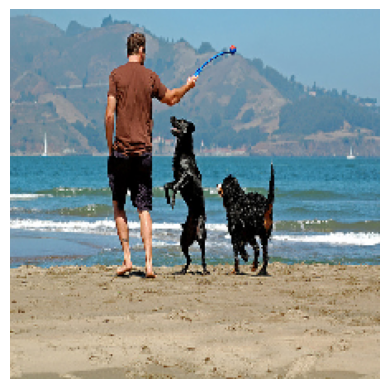

Caption: startseq a man in a red shirt is standing on a rock endseq


In [62]:
img_path = "/content/Images/1075867198_27ca2e7efe.jpg"
img = load_img(img_path, target_size=(224,224))
img = img_to_array(img) / 255.0

# Extract features
img_expanded = np.expand_dims(img, axis=0)
test_feature = feature_extractor.predict(img_expanded, verbose=0)

# Wrap into dict (to match training style)
test_features = {"test_image": test_feature}

# Generate caption
caption = predict(caption_model, "test_image", tokenizer, max_len_sentence, test_features)

# Show result
plt.imshow(img)
plt.axis("off")
plt.show()
print("Caption:", caption)


In [67]:
# import pickle

# with open("features.pkl", "wb") as f:
#     pickle.dump(features, f)


In [52]:
from google.colab import files

# files.download("captioner.h5")
files.download("features.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>